# TESTING SINGLE SUBJECT AND DIMENSIONALITY REDUCTION

In [1]:
import nibabel as nb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import os
from os.path import join
from glob import glob as glob
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy import stats
import matplotlib.gridspec as gridspec
import nighres
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
source_dir = '/data/neuralabc/source/MPI_CBS/MPM_DTI/source/'
seg_dir = '/data/neuralabc/carfra/QuantMetComp/source/masks_created/'
out_dir = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/'

all_dirs = glob(source_dir+'*')
sub_ids = [os.path.basename(x) for x in all_dirs]
name = ['FA','MD','MTsat','PDsat','R1','$R2^*$']  #hard-coded, but I know what they are!

In [4]:
def get_sub_data(in_dir, sub_id):
    """
    Loads an individual subject's data for all modalities
    
    - in_dir {str} : sdsdsds
    """
    
    img1 = nb.load(join(in_dir,'{}_FA_reg.nii.gz'.format(sub_id)))
    img2 = nb.load(join(in_dir,'{}_MD_reg.nii.gz'.format(sub_id)))
    img3 = nb.load(join(in_dir,'{}_MTsat.nii.gz'.format(sub_id)))
    img4 = nb.load(join(in_dir,'{}_PDsat.nii.gz'.format(sub_id)))
    img5 = nb.load(join(in_dir,'{}_R1.nii.gz'.format(sub_id)))
    img6 = nb.load(join(in_dir,'{}_R2s_OLS.nii.gz'.format(sub_id)))
    
    d1 = img1.get_data()
    d2 = img2.get_data()
    d3 = img3.get_data()
    d4 = img4.get_data()
    d5 = img5.get_data()
    d6 = img6.get_data()
        
#     d = [d1,d2,d3,d4,d5,d6]
#     m = [mk>0 for mk in d]
#     mask = np.ones_like(m[0])
#     for iii in m:
#         mask = mask*iii

    d = np.stack((d1,d2,d3,d4,d5,d6),axis=3)
    mask = np.prod(d>0,axis=3).astype(bool)
    
    return {'data':d,'mask':mask,'img':img1}
    
def get_cubed_array_labels_3d(shape, cube_subset_dim = 10):
    """
    Break a 3d array into cubes of cube_dim. Throw away extras if array is not a perfect cube
    :param shape:              - 3d matrix shape
    :param cube_subset_dim:    - size, in voxels, of one dimension of cube
    :return:                   - matrix of labeled cubes (or appx) of size cube_dim*cube_dim*cube_dim
    """
    import numpy as np


    #we make the matrix cubic to make the calculations easier, toss out the extras at the end
    max_dim = np.max(shape)
    num_cubes_per_dim = np.ceil(max_dim / cube_subset_dim).astype(int)
    d = np.zeros((max_dim,max_dim,max_dim))

    #determine the size of each cube based on the number of cubes that we will cut the supercube into (yes, this is basically the reverse of above)
    x_span = np.ceil(max_dim / num_cubes_per_dim).astype(int)
    y_span = x_span
    z_span = x_span
    print("Voxel span for single cube dimension: {}".format(x_span))

    cube_idx = 0
    for ix in np.arange(0, num_cubes_per_dim):
        for iy in np.arange(0, num_cubes_per_dim):
            for iz in np.arange(0, num_cubes_per_dim):
                cube_idx += 1
                x0 = ix*x_span
                y0 = iy*y_span
                z0 = iz*z_span
                d[x0 : x0 + x_span, y0 : y0 + y_span, z0 : z0 + z_span] = cube_idx
    return (d[0:shape[0],0:shape[1],0:shape[2]]).astype(np.uint64) #return only the dims that we requested, discard the extras at the edges

# PCA

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f539b6ccc10>)

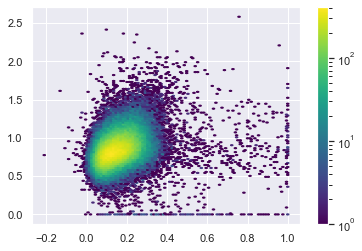

In [5]:
seg_by = 'cortex_MD_R2_cap'
sub_id = sub_ids[0]

mesh_dir = '/data/neuralabc/carfra/QuantMetComp/source/masks_created/'

in_dir = join(source_dir,sub_id)
output_dir = join(out_dir,'PCA',sub_id,seg_by) 
dd = get_sub_data(in_dir,sub_id)
d = dd['data']
mask_dir = join(seg_dir,sub_id)
mask = nb.load(join(mask_dir,seg_by+'.nii.gz')).get_data().astype(bool)

if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print('Created your directory: {}'.format(output_dir))

for iii in np.arange(d.shape[-1]):
    data = d[...,iii][mask]
    if iii == 0:
        df = pd.DataFrame({name[iii]:data})
    else:
        df[name[iii]] = data
df['FA'][df['FA']>1] = 1
plt.figure(),plt.hexbin(df['FA'],df['MTsat'],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100)),plt.colorbar()


In [6]:
#create dataframe and remove the index == 0 (i.e., the background)
from scipy.stats import zscore
df = df.apply(zscore)
print(df.mean())
print(df.std())

FA       -2.351636e-07
MD       -4.713104e-07
MTsat    -5.350537e-08
PDsat    -5.403283e-08
R1        2.866998e-07
$R2^*$   -5.990416e-07
dtype: float32
FA        0.999980
MD        0.999985
MTsat     0.999981
PDsat     0.999973
R1        0.999984
$R2^*$    0.999980
dtype: float32


In [7]:
reg_dir = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/Corticalmasked_vs_subcortical/'
reg_data = pd.read_csv(join(reg_dir,'cortical_sheath.csv'), index_col=0)#'cortical_sheath.csv'), index_col=0)
reg_data = reg_data.apply(zscore)
print("loaded")

pca = PCA(n_components=6)
pca.fit(reg_data)
res = pca.transform(df)

print(pca.explained_variance_ratio_)
first_pc = pca.components_[0]
second_pc = pca.components_[1]
third_pc = pca.components_[2]
fourth_pc = pca.components_[3]
fifth_pc = pca.components_[4]
sixth_pc = pca.components_[5]
print(first_pc)
print(second_pc)
print(third_pc)
print(fourth_pc)
print(fifth_pc)
print(sixth_pc)
# plt.hexbin(res[:,0],res[:,1],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100)),plt.colorbar()
# plt.show();

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


loaded
[0.44023111 0.18894147 0.1610188  0.09685575 0.08229477 0.03065811]
[ 0.40230216 -0.38307885  0.4753233  -0.34754355  0.52937891  0.25385581]
[ 0.29442039 -0.22760686 -0.24474937 -0.46656764 -0.11256047 -0.75581365]
[ 0.46105172 -0.54143968  0.01250975  0.58967735 -0.38133187  0.03137702]
[-0.20124824 -0.47210563 -0.65268693 -0.30381514 -0.02582753  0.46652384]
[-0.70422325 -0.53416486  0.3342982   0.11154428  0.06573614 -0.30036454]
[-0.04969578  0.00854193  0.41982555 -0.45723404 -0.74611381  0.23548905]


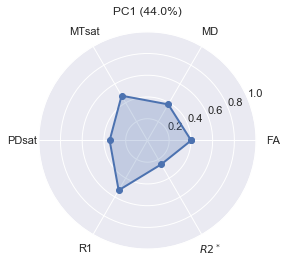

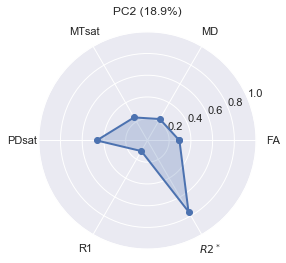

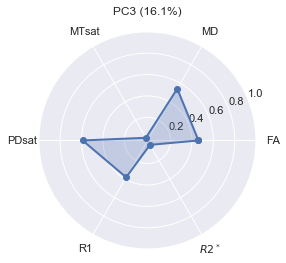

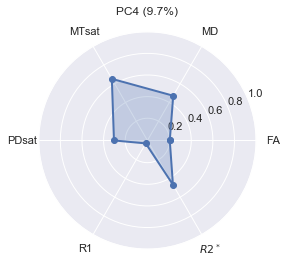

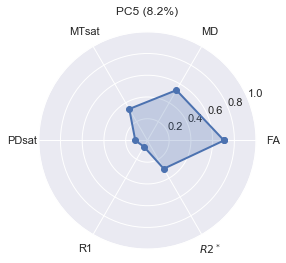

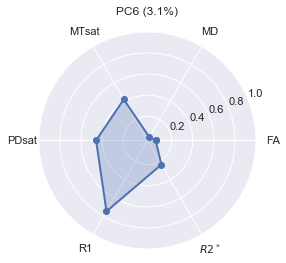

In [8]:
import matplotlib.pyplot as plt
import numpy as np

labels=df.columns
markers = [0.2,0.4,0.6,0.8,1]
str_markers = ["0.2", "0.4", "0.6", "0.8", "1"]

def make_radar_chart(name, stats, attribute_labels = labels, plot_markers = markers, 
                     plot_str_markers = str_markers):

    labels = np.array(attribute_labels)

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats,[stats[0]]))
    angles = np.concatenate((angles,[angles[0]]))

    fig= plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    plt.yticks(markers)
    ax.set_title(name)
    ax.grid(True)

    fig.savefig("/data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/cortex/"+name[0:3]+".svg")

    return plt.show()

for ii in range(6):
    make_radar_chart("PC{} ({}%)".format(ii+1,round(pca.explained_variance_ratio_[ii]*100,1)), np.absolute(pca.components_[ii])) # example

In [28]:
join(output_dir)+".svg"

'/data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/cortex_MD_R2_cap.svg'

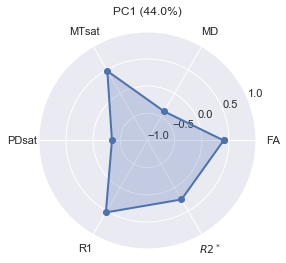

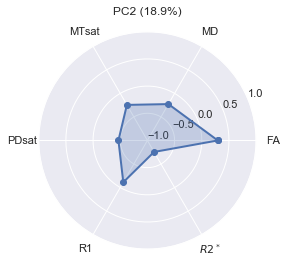

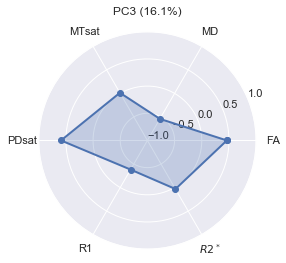

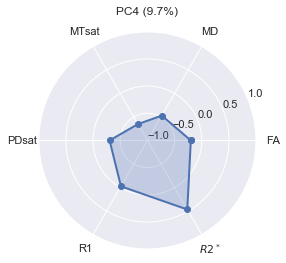

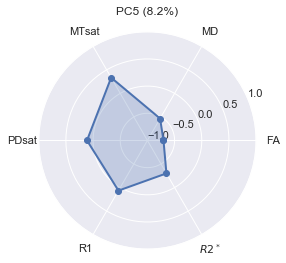

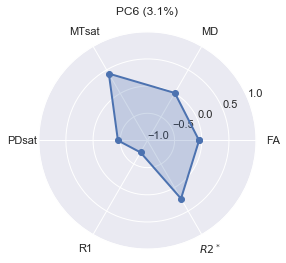

In [15]:
labels=df.columns
markers = [-1,-0.5,0,0.5,1]
str_markers = ["-1","-0.5", "0", "0.5", "1"]
# markers = [0,0.5,1]
# str_markers = ["0", "0.5", "1"]


def make_radar_chart(name, stats, attribute_labels = labels, plot_markers = markers, 
                     plot_str_markers = str_markers):

    labels = np.array(attribute_labels)

    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats,[stats[0]]))
    angles = np.concatenate((angles,[angles[0]]))

    fig= plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    plt.yticks(markers)
    ax.set_title(name)
    ax.grid(True)

    fig.savefig(join(output_dir,name[0:3])+".svg")

    return plt.show()

for ii in range(6):
    make_radar_chart("PC{} ({}%)".format(ii+1,round(pca.explained_variance_ratio_[ii]*100,1)), pca.components_[ii]) # example

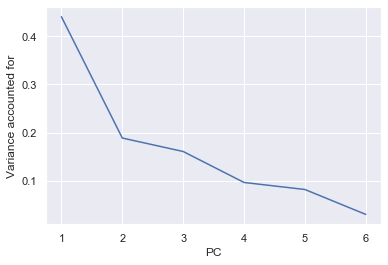

In [16]:
#import plotly.plotly as py
#import plotly.tools as tls

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
plt.plot(np.array([1,2,3,4,5,6]),pca.explained_variance_ratio_)
xlabel('PC')
ylabel('Variance accounted for')
plt.style.use(['seaborn-whitegrid'])

fig.savefig(join(output_dir,'VarianceAccountedFor.svg'))

In [10]:
name

['FA', 'MD', 'MTsat', 'PDsat', 'R1', '$R2^*$']

[[ 0.39253352  0.25655412]
 [-0.45589922 -0.09209774]
 [ 0.50027894  0.05285283]
 [-0.33741266  0.52579028]
 [ 0.52338691  0.01023508]
 [ 0.00362813  0.80395547]]


<IPython.core.display.Javascript object>


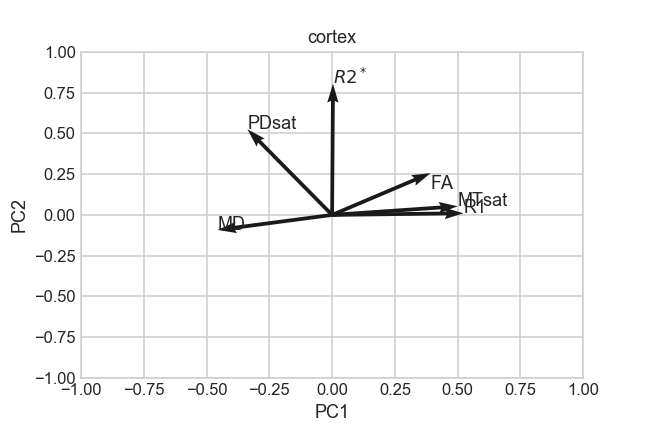

In [32]:
for ii in range(len(name)):
    dim = np.zeros(len(name))
    dim[ii] = 1
    dim_prjct1 = np.dot(dim, pca.components_[0])
    dim_prjct2 = np.dot(dim, pca.components_[1])
    if ii==0:
        prjction = np.array([[dim_prjct1, dim_prjct2]])
    else:
        prjction = np.vstack([prjction,[dim_prjct1, dim_prjct2]])
print(prjction)

fig = plt.figure()
origin = [0], [0] # origin point
plt.quiver(*origin, prjction[:,0], prjction[:,1], angles='xy', scale_units='xy', scale=1)
plt.xlim(-1,1)
plt.ylim(-1,1)
for label, x, y in zip(name, prjction[:, 0], prjction[:, 1]):
    if (label == 'FA'):
        plt.annotate(label, xy=(x, y-0.1))
#     elif (label == 'MD'):
#         plt.annotate(label, xy=(x-0.1, y))
#     elif (label == 'PDsat'):
#         plt.annotate(label, xy=(x-0.1, y))
#     elif (label == '$R2^*$'):
#         plt.annotate(label, xy=(x-0.1, y))
#     elif (label == 'MTsat'):
#         plt.annotate(label, xy=(x-0.15, y))
#     elif (label == 'R1'):
#         plt.annotate(label, xy=(x-0.1, y))
    else:
        plt.annotate(label, xy=(x, y))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(seg_by)
plt.style.use(['seaborn-whitegrid'])

fig.savefig(join(output_dir,'PCA_1_2.png'))


[[ 0.39253352  0.25655412 -0.27075283]
 [-0.45589922 -0.09209774  0.39525113]
 [ 0.50027894  0.05285283 -0.20467416]
 [-0.33741266  0.52579028 -0.57146675]
 [ 0.52338691  0.01023508  0.37101212]
 [ 0.00362813  0.80395547  0.51415338]]


<IPython.core.display.Javascript object>


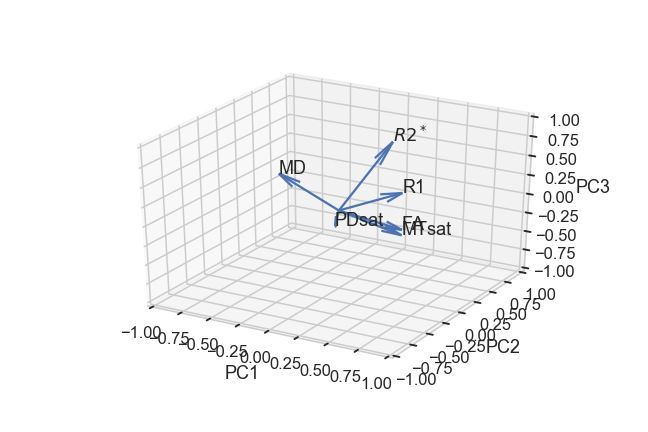

Text(0.5, 0, 'PC3')

In [21]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
%matplotlib notebook
for ii in range(len(name)):
    dim = np.zeros(len(name))
    dim[ii] = 1
    dim_prjct1 = np.dot(dim, pca.components_[0])
    dim_prjct2 = np.dot(dim, pca.components_[1])
    dim_prjct3 = np.dot(dim, pca.components_[2])
    if ii==0:
        prjction = np.array([[dim_prjct1, dim_prjct2, dim_prjct3]])
    else:
        prjction = np.vstack([prjction,[dim_prjct1, dim_prjct2, dim_prjct3]])
print(prjction)

fig = plt.figure()
ax = fig.gca(projection='3d')

origin = [0], [0], [0] # origin point
ax.quiver3D(*origin, prjction[:,0], prjction[:,1], prjction[:,2])
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
for label, x, y, z in zip(name, prjction[:, 0], prjction[:, 1], prjction[:, 2]):
    ax.text3D(x, y, z, label)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')


In [11]:
print(mask.sum())
print(res.shape)

26319
(26319, 6)


In [10]:
output_dir = output_dir+'_l'

In [12]:
for ii in range(6):
    brain = np.zeros_like(dd['data'][...,0])
    brain[mask] = res[:,ii]
    out_name = join(output_dir,sub_id+'_PC_{}_{}.nii.gz'.format(ii+1, seg_by))
    new_img = nb.Nifti1Image(brain,affine=dd['img'].affine,header=dd['img'].header)
    new_img.to_filename(out_name)
    
    mesh = nighres.surface.levelset_to_mesh(join(mesh_dir,sub_id,'cortex_ls_l.nii.gz'), 
                                            connectivity='18/6', 
                                            level=0.0, 
                                            inclusive=True, 
                                            save_data=False)
    
    nighres.surface.surface_mesh_mapping(intensity_image = out_name, 
                                         surface_mesh = mesh['result'],#join(mesh_dir,sub_id,sub_id+'_l2m-mesh.vtk'), 
                                         inflated_mesh=None, 
                                         mapping_method='closest_point', 
                                         save_data=True, 
                                         overwrite=True, 
                                         output_dir=join(output_dir,'mapped'), 
                                         file_name=os.path.basename(out_name).strip('.nii.gz'))




Levelset to Mesh

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/subcortex/mapped/

Levelset to Mesh

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/subcortex/mapped/

Levelset to Mesh

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/subcortex/mapped/

Levelset to Mesh

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/subcortex/mapped/

Levelset to Mesh

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/subcortex/mapped/

Levelset to Mesh

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1001/subcortex/mapped/


# ICA

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7ff52d91ce48>)

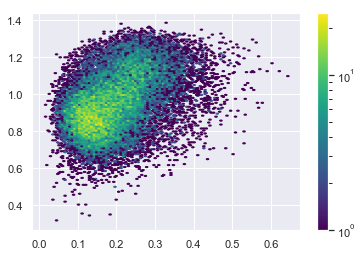

In [4]:
seg_by = 'subcortex'
sub_id = sub_ids[0]

mesh_dir = '/data/neuralabc/carfra/QuantMetComp/source/masks_created/'

in_dir = join(source_dir,sub_id)
output_dir = join(out_dir,'ICA',sub_id,seg_by+'3') 
dd = get_sub_data(in_dir,sub_id)
d = dd['data']
mask_dir = join(seg_dir,sub_id)
mask = nb.load(join(mask_dir,seg_by+'.nii.gz')).get_data().astype(bool)

if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print('Created your directory: {}'.format(output_dir))

for iii in np.arange(d.shape[-1]):
    data = d[...,iii][mask]
    if iii == 0:
        df = pd.DataFrame({name[iii]:data})
    else:
        df[name[iii]] = data
df['FA'][df['FA']>1] = 1
plt.figure(),plt.hexbin(df['FA'],df['MTsat'],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100)),plt.colorbar()

In [5]:
#create dataframe and remove the index == 0 (i.e., the background)
from scipy.stats import zscore
df = df.apply(zscore)
print(df.mean())
print(df.std())

FA       -3.114379e-07
MD        8.382612e-08
MTsat     2.531114e-07
PDsat     1.386561e-06
R1        7.053902e-07
$R2^*$    3.033806e-07
dtype: float32
FA        1.000018
MD        1.000018
MTsat     1.000017
PDsat     1.000019
R1        1.000016
$R2^*$    1.000018
dtype: float32


In [6]:
reg_dir = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/Cortical_vs_subcortical/'
reg_data = pd.read_csv(join(reg_dir,'subcortical_GM.csv'), index_col=0)#'cortical_sheath.csv'), index_col=0)
reg_data = reg_data.apply(zscore)
print("loaded")

ica = FastICA(n_components=3)
ica.fit(reg_data)
res = ica.transform(df)

#print(ica.explained_variance_ratio_)
# first_ic = ica.components_[0]
# second_ic = ica.components_[1]
# third_ic = ica.components_[2]
# fourth_ic = ica.components_[3]
# fifth_ic = ica.components_[4]
# sixth_ic = ica.components_[5]
# print(first_ic)
# print(second_ic)
# print(third_ic)
# print(fourth_ic)
# print(fifth_ic)
# print(sixth_ic)
# plt.hexbin(res[:,0],res[:,1],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100)),plt.colorbar()
# plt.show();

/opt/quarantine/anaconda3/2018.12/install/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


loaded


In [15]:
###these are for plotting dimensions onto IC's
import math
summation1 = 0
for iii in ica.components_[1]:
    summation1 += iii**2
summation1 = math.sqrt(summation1)
mul1 = 1/summation1


In [22]:
import math
summation2 = 0
for iii in ica.components_[2]:
    summation2 += iii**2
summation2 = math.sqrt(summation2)
mul2 = 1/summation2

[[ 0.72985207 -0.02771109]
 [-0.1467748   0.04905513]
 [-0.28202768  0.68370187]
 [-0.13030413 -0.16921224]
 [-0.59091249 -0.6966232 ]
 [ 0.00876184  0.12434138]]


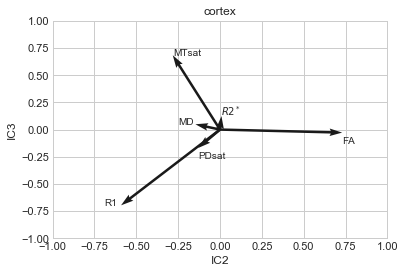

In [24]:
for ii in range(len(name)):
    dim = np.zeros(len(name))
    dim[ii] = 1
    dim_prjct1 = np.dot(dim, ica.components_[1]*mul1)       #making equal to 1
    dim_prjct2 = np.dot(dim, ica.components_[2]*mul2)
    if ii==0:
        prjction = np.array([[dim_prjct1, dim_prjct2]])
    else:
        prjction = np.vstack([prjction,[dim_prjct1, dim_prjct2]])
print(prjction)

fig = plt.figure()
origin = [0], [0] # origin point
plt.quiver(*origin, prjction[:,0], prjction[:,1], angles='xy', scale_units='xy', scale=1)
plt.xlim(-1,1)
plt.ylim(-1,1)
for label, x, y in zip(name, prjction[:, 0], prjction[:, 1]):
    if (label == 'FA'):
        plt.annotate(label, xy=(x, y-0.1))
    elif (label == 'MD'):
        plt.annotate(label, xy=(x-0.1, y))
    elif (label == 'PDsat'):
        plt.annotate(label, xy=(x, y-0.1))
#     elif (label == '$R2^*$'):
#         plt.annotate(label, xy=(x-0.1, y))
#     elif (label == 'MTsat'):
#         plt.annotate(label, xy=(x-0.15, y))
    elif (label == 'R1'):
        plt.annotate(label, xy=(x-0.1, y))
    else:
        plt.annotate(label, xy=(x, y))
plt.xlabel('IC2')
plt.ylabel('IC3')
plt.title(seg_by)
plt.style.use(['seaborn-whitegrid'])

fig.savefig(join(output_dir,'ICA_2_3.png'))


In [7]:
print(mask.sum())
print(res.shape)

26535
(26535, 3)


In [13]:
# output_dir = output_dir+"_l"
# if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
#         print('Created your directory: {}'.format(output_dir))

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1001/cortex3_l


In [8]:
for ii in range(6):
    brain = np.zeros_like(dd['data'][...,0])
    brain[mask] = res[:,ii]
    out_name = join(output_dir,sub_id+'_IC_{}_{}.nii.gz'.format(ii+1, seg_by))
    new_img = nb.Nifti1Image(brain,affine=dd['img'].affine,header=dd['img'].header)
    new_img.to_filename(out_name)
    
    mesh = nighres.surface.levelset_to_mesh(join(mesh_dir,sub_id,'subcortex.nii.gz'), 
                                            connectivity='18/6', 
                                            level=0.0, 
                                            inclusive=True, 
                                            save_data=False)
    
    nighres.surface.surface_mesh_mapping(intensity_image = out_name, 
                                         surface_mesh = mesh['result'],#join(mesh_dir,sub_id,sub_id+'_l2m-mesh.vtk'), 
                                         inflated_mesh=None, 
                                         mapping_method='closest_point', 
                                         save_data=True, 
                                         overwrite=True, 
                                         output_dir=join(output_dir,'mapped'), 
                                         file_name=os.path.basename(out_name).strip('.nii.gz'))
    
#     brain_flip = brain*(-1)
#     new_img_flip = nb.Nifti1Image(brain_flip,affine=dd['img'].affine,header=dd['img'].header)
#     nighres.surface.surface_mesh_mapping(intensity_image = new_img_flip, 
#                                          surface_mesh = mesh['result'],#join(mesh_dir,sub_id,sub_id+'_l2m-mesh.vtk'), 
#                                          inflated_mesh=None, 
#                                          mapping_method='closest_point', 
#                                          save_data=True, 
#                                          overwrite=True, 
#                                          output_dir=join(output_dir,'flip/mapped'), 
#                                          file_name=os.path.basename(join(output_dir,sub_id+'_IC_{}_{}.nii.gz'.format(ii+1, seg_by))).strip('.nii.gz'))

    

IndexError: index 3 is out of bounds for axis 1 with size 3

# Spectral Embedding

hello
hello2


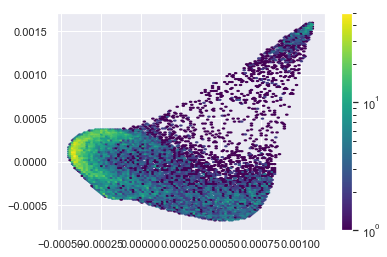

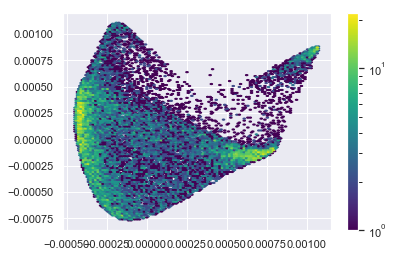

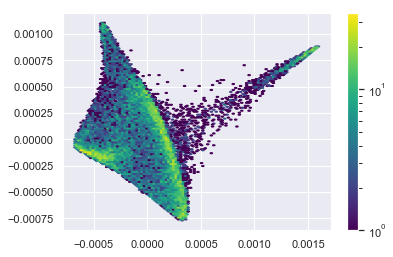

In [9]:
from sklearn.manifold import SpectralEmbedding

emb = SpectralEmbedding(n_components=3, n_jobs=20,n_neighbors=250)
# print('hello')
# fit_emb = emb.fit(df.values)
print('hello')
emb_results = emb.fit_transform(df.values)
print('hello2')
plt.figure()
plt.hexbin(emb_results[:,0],emb_results[:,1],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100))
plt.colorbar()
plt.figure()
plt.hexbin(emb_results[:,0],emb_results[:,2],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100))
plt.colorbar()
plt.figure()
plt.hexbin(emb_results[:,1],emb_results[:,2],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100))
plt.colorbar()

In [10]:
sub_id

'sub1001'

In [15]:
if not os.path.exists(join(out_dir,"SPECT")):
    os.makedirs(join(out_dir,"SPECT"))
    print('Created your directory: {}'.format(out_dir))

for ii in range(3):
    brain = zeros_like(dd['data'][...,0])
    brain[mask] = emb_results[:,ii]
    new_img = nb.Nifti1Image(brain,affine=dd['img'].affine,header=dd['img'].header)
    new_img.to_filename(join(out_dir,"SPECT",sub_id+'_{}_SPECT_{}.nii.gz'.format(seg_by, ii+1)))

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/


## Extra

(<matplotlib.collections.PolyCollection at 0x7f0b9016a0b8>,
 <matplotlib.colorbar.Colorbar at 0x7f0b805b3da0>)

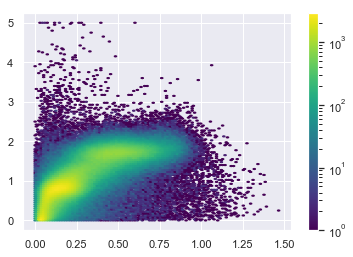

In [5]:
sub_id = sub_ids[0]
in_dir = '/data/neuralabc/source/MPI_CBS/MPM_DTI/source/{}/'.format(sub_id)
dd = get_sub_data(in_dir,sub_id)
d = dd['data']
mask = dd['mask']

for iii in np.arange(d.shape[-1]):
    data = d[...,iii][mask]
    if iii == 0:
        df = pd.DataFrame({name[iii]:data})
    else:
        df[name[iii]] = data
plt.hexbin(df['FA'],df['MT'],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100)),plt.colorbar()

Voxel span for single cube dimension: 3


Text(0.5, 1.0, 'Cubed subsets (mean)')

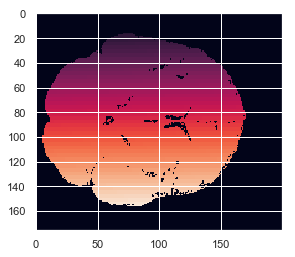

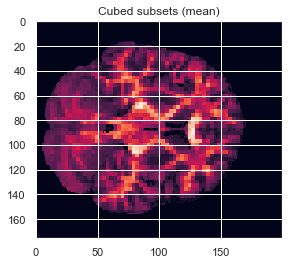

In [17]:
#generate cubes to ARTIFICIALLY segment the data
cube_subset_dim = 3
cubed_3d = get_cubed_array_labels_3d(d.shape,cube_subset_dim=cube_subset_dim)

cubed_mask = np.multiply(mask, cubed_3d).astype(np.uint32) #apply the cube to the data

#there are much faster ways to do this assignment, other than a loop :-/
np.unique(cubed_mask).shape
plt.imshow(cubed_mask[:,:,60])
cubed_d = np.zeros_like(d)
for cubed_idx in np.unique(cubed_mask):
    if cubed_idx ==0:
        pass
    else:
        cubed_d[cubed_mask==cubed_idx,:] = np.mean(d[cubed_mask==cubed_idx,:],axis=0) #mean of each modality
plt.figure()
plt.imshow(cubed_d[:,:,60,0])
plt.title('Cubed subsets (mean)')


In [18]:
#there are much faster ways to do this
unique_cubed_idxs = np.unique(cubed_mask)
_t = np.zeros((np.unique(cubed_mask).shape[0],len(name)))
for row in range(_t.shape[0]):
#     print(row,end=', ')
    idx_c = unique_cubed_idxs[row]
    if idx_c == 0:
        pass
    else:
        _t[row,:] = np.mean(d[cubed_mask==idx_c,:],axis=0) #mean of each modality

In [19]:
#create dataframe and remove the index ==0 (i.e., the background)
from scipy.stats import zscore
df_cubed = pd.DataFrame(_t, columns=name)
df_cubed = df_cubed.iloc[1:,:]
print(df_cubed.head())
df_cubed = df_cubed.apply(zscore)
print(df_cubed.mean())
print(df_cubed.std())


         FA        MD        MT         PD        R1         R2
1  0.198089  0.000733  0.449192  22.368738  0.500475  47.313015
2  0.168911  0.000930  0.421322  12.045341  0.601955  30.483969
3  0.212922  0.000826  0.689477   8.477685  0.635319  12.157620
4  0.123696  0.000901  0.504540  32.481644  0.525903  31.179525
5  0.202715  0.000753  0.507734  33.778549  0.531629  27.568634
FA   -3.293176e-16
MD    1.151351e-16
MT    1.307292e-16
PD    4.424500e-16
R1   -6.482740e-17
R2    1.393724e-16
dtype: float64
FA    1.000009
MD    1.000009
MT    1.000009
PD    1.000009
R1    1.000009
R2    1.000009
dtype: float64


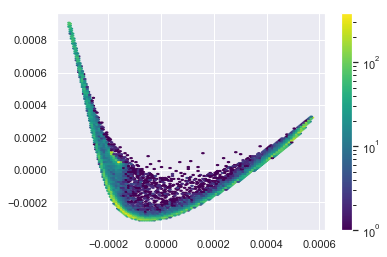

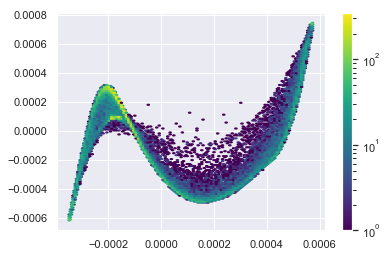

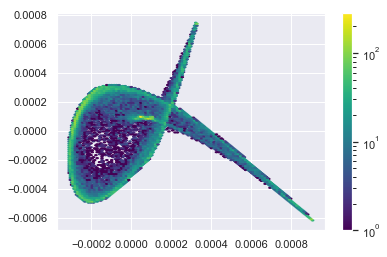

In [20]:
from sklearn.manifold import SpectralEmbedding

emb = SpectralEmbedding(n_components=3, n_jobs=20,n_neighbors=250)
fit_emb = emb.fit(df_cubed.values)
emb_results = emb.fit_transform(df_cubed.values)
plt.figure()
plt.hexbin(emb_results[:,0],emb_results[:,1],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100))
plt.colorbar()
plt.figure()
plt.hexbin(emb_results[:,0],emb_results[:,2],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100))
plt.colorbar()
plt.figure()
plt.hexbin(emb_results[:,1],emb_results[:,2],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100))
plt.colorbar()

In [21]:
new_d = emb_results[:,0]
d_res = np.zeros_like(dd['img'].get_data())
for idx1,cubed_idx in enumerate(unique_cubed_idxs):
    if cubed_idx ==0:
        pass
    else:
        d_res[cubed_mask==cubed_idx] = new_d[idx1-1] #offset by one since we skip the 0th row
new_img = nb.Nifti1Image(d_res,affine=dd['img'].affine,header=dd['img'].header)
new_img.to_filename('/data/neuralabc/carfra/QuantMetComp/processing/MPM/subXXXX_cubed_{}_SpectEmb_1.nii.gz'.format(cube_subset_dim))


new_d = emb_results[:,1]
d_res = np.zeros_like(dd['img'].get_data())
for idx1,cubed_idx in enumerate(unique_cubed_idxs):
    if cubed_idx ==0:
        pass
    else:
        d_res[cubed_mask==cubed_idx] = new_d[idx1-1] #offset by one since we skip the 0th row
new_img = nb.Nifti1Image(d_res,affine=dd['img'].affine,header=dd['img'].header)
new_img.to_filename('/data/neuralabc/carfra/QuantMetComp/processing/MPM/subXXXX_cubed_{}_SpectEmb_2.nii.gz'.format(cube_subset_dim))



In [22]:
emb_results

array([[-1.59020440e-04,  5.01833988e-05,  1.04097074e-04],
       [-1.57519742e-04,  4.85771692e-05,  1.06109628e-04],
       [-1.56514930e-04,  4.81499870e-05,  1.06709192e-04],
       ...,
       [-1.62849462e-04,  5.42462948e-05,  1.01055020e-04],
       [-1.59434250e-04,  4.92158198e-05,  1.02110922e-04],
       [-1.57806589e-04,  4.80543070e-05,  1.05518425e-04]])

In [6]:
df_norm = (df - df.mean()) / df.std()
df_norm.mean()
#??????

FA   -0.000011
MD    0.000091
MT    0.000087
PD   -0.002254
R1    0.000132
R2    0.000062
dtype: float32

In [18]:
pca = PCA(n_components=6)
pca.fit(df_norm)
results = pca.transform(df_norm)

In [19]:
print(pca.explained_variance_ratio_)

[0.61068469 0.16309095 0.09935264 0.07950236 0.03584622 0.01152313]


In [20]:
first_pc = pca.components_[0]
second_pc = pca.components_[1]
third_pc = pca.components_[2]
print(first_pc)
print(second_pc)
print(third_pc)
#PC1

[ 0.44263814 -0.37672653  0.48298393 -0.39915988  0.5018312   0.13308627]
[ 0.01143684 -0.01225952 -0.03941211  0.25225491 -0.03690046  0.96600797]
[ 0.47634881  0.86392717  0.13940169 -0.00816625  0.08339939  0.01633007]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f71f04a7048>)

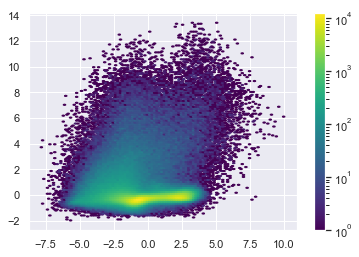

In [51]:
plt.figure(),plt.hexbin(results[:,0],results[:,1],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100)),plt.colorbar()

In [63]:
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=4, algorithm='arpack')
svd.fit(df_norm_all)
results3 = svd.transform(df_norm_all)
print(svd.explained_variance_ratio_)
first_pc3 = svd.components_[0]
second_pc3 = svd.components_[1]
third_pc3 = svd.components_[2]
fourth_pc3 = svd.components_[3]
print(first_pc3)
print(second_pc3)
print(third_pc3)
print(fourth_pc3)


[0.60355324 0.31460255 0.16830386 0.05832814]
[0.29118443 0.2922118  0.40371713 0.57362294 0.47277883 0.3380433 ]
[ 0.51992816 -0.5705404   0.38240096 -0.4344383   0.26025918 -0.03815905]
[-0.11608311 -0.20261483 -0.18345486 -0.17620781 -0.10003557  0.93314517]
[ 0.65372866  0.59335804 -0.22464664 -0.33646253 -0.22529925  0.07830746]


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f71f0c88ba8>)

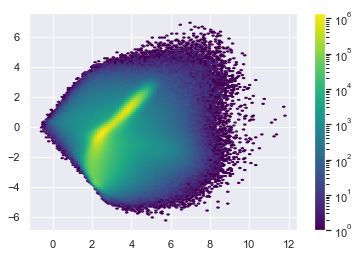

In [64]:
plt.figure(),plt.hexbin(results3[:,0],results3[:,1],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100)),plt.colorbar()

In [76]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1474500 samples in 2.187s...
[t-SNE] Computed neighbors for 1474500 samples in 122.448s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1474500
[t-SNE] Computed conditional probabilities for sample 2000 / 1474500
[t-SNE] Computed conditional probabilities for sample 3000 / 1474500
[t-SNE] Computed conditional probabilities for sample 4000 / 1474500
[t-SNE] Computed conditional probabilities for sample 5000 / 1474500
[t-SNE] Computed conditional probabilities for sample 6000 / 1474500
[t-SNE] Computed conditional probabilities for sample 7000 / 1474500
[t-SNE] Computed conditional probabilities for sample 8000 / 1474500
[t-SNE] Computed conditional probabilities for sample 9000 / 1474500
[t-SNE] Computed conditional probabilities for sample 10000 / 1474500
[t-SNE] Computed conditional probabilities for sample 11000 / 1474500
[t-SNE] Computed conditional probabilities for sample 12000 / 1474500
[t-SNE] Computed co

[t-SNE] Computed conditional probabilities for sample 143000 / 1474500
[t-SNE] Computed conditional probabilities for sample 144000 / 1474500
[t-SNE] Computed conditional probabilities for sample 145000 / 1474500
[t-SNE] Computed conditional probabilities for sample 146000 / 1474500
[t-SNE] Computed conditional probabilities for sample 147000 / 1474500
[t-SNE] Computed conditional probabilities for sample 148000 / 1474500
[t-SNE] Computed conditional probabilities for sample 149000 / 1474500
[t-SNE] Computed conditional probabilities for sample 150000 / 1474500
[t-SNE] Computed conditional probabilities for sample 151000 / 1474500
[t-SNE] Computed conditional probabilities for sample 152000 / 1474500
[t-SNE] Computed conditional probabilities for sample 153000 / 1474500
[t-SNE] Computed conditional probabilities for sample 154000 / 1474500
[t-SNE] Computed conditional probabilities for sample 155000 / 1474500
[t-SNE] Computed conditional probabilities for sample 156000 / 1474500
[t-SNE

[t-SNE] Computed conditional probabilities for sample 284000 / 1474500
[t-SNE] Computed conditional probabilities for sample 285000 / 1474500
[t-SNE] Computed conditional probabilities for sample 286000 / 1474500
[t-SNE] Computed conditional probabilities for sample 287000 / 1474500
[t-SNE] Computed conditional probabilities for sample 288000 / 1474500
[t-SNE] Computed conditional probabilities for sample 289000 / 1474500
[t-SNE] Computed conditional probabilities for sample 290000 / 1474500
[t-SNE] Computed conditional probabilities for sample 291000 / 1474500
[t-SNE] Computed conditional probabilities for sample 292000 / 1474500
[t-SNE] Computed conditional probabilities for sample 293000 / 1474500
[t-SNE] Computed conditional probabilities for sample 294000 / 1474500
[t-SNE] Computed conditional probabilities for sample 295000 / 1474500
[t-SNE] Computed conditional probabilities for sample 296000 / 1474500
[t-SNE] Computed conditional probabilities for sample 297000 / 1474500
[t-SNE

[t-SNE] Computed conditional probabilities for sample 413000 / 1474500
[t-SNE] Computed conditional probabilities for sample 414000 / 1474500
[t-SNE] Computed conditional probabilities for sample 415000 / 1474500
[t-SNE] Computed conditional probabilities for sample 416000 / 1474500
[t-SNE] Computed conditional probabilities for sample 417000 / 1474500
[t-SNE] Computed conditional probabilities for sample 418000 / 1474500
[t-SNE] Computed conditional probabilities for sample 419000 / 1474500
[t-SNE] Computed conditional probabilities for sample 420000 / 1474500
[t-SNE] Computed conditional probabilities for sample 421000 / 1474500
[t-SNE] Computed conditional probabilities for sample 422000 / 1474500
[t-SNE] Computed conditional probabilities for sample 423000 / 1474500
[t-SNE] Computed conditional probabilities for sample 424000 / 1474500
[t-SNE] Computed conditional probabilities for sample 425000 / 1474500
[t-SNE] Computed conditional probabilities for sample 426000 / 1474500
[t-SNE

[t-SNE] Computed conditional probabilities for sample 539000 / 1474500
[t-SNE] Computed conditional probabilities for sample 540000 / 1474500
[t-SNE] Computed conditional probabilities for sample 541000 / 1474500
[t-SNE] Computed conditional probabilities for sample 542000 / 1474500
[t-SNE] Computed conditional probabilities for sample 543000 / 1474500
[t-SNE] Computed conditional probabilities for sample 544000 / 1474500
[t-SNE] Computed conditional probabilities for sample 545000 / 1474500
[t-SNE] Computed conditional probabilities for sample 546000 / 1474500
[t-SNE] Computed conditional probabilities for sample 547000 / 1474500
[t-SNE] Computed conditional probabilities for sample 548000 / 1474500
[t-SNE] Computed conditional probabilities for sample 549000 / 1474500
[t-SNE] Computed conditional probabilities for sample 550000 / 1474500
[t-SNE] Computed conditional probabilities for sample 551000 / 1474500
[t-SNE] Computed conditional probabilities for sample 552000 / 1474500
[t-SNE

[t-SNE] Computed conditional probabilities for sample 711000 / 1474500
[t-SNE] Computed conditional probabilities for sample 712000 / 1474500
[t-SNE] Computed conditional probabilities for sample 713000 / 1474500
[t-SNE] Computed conditional probabilities for sample 714000 / 1474500
[t-SNE] Computed conditional probabilities for sample 715000 / 1474500
[t-SNE] Computed conditional probabilities for sample 716000 / 1474500
[t-SNE] Computed conditional probabilities for sample 717000 / 1474500
[t-SNE] Computed conditional probabilities for sample 718000 / 1474500
[t-SNE] Computed conditional probabilities for sample 719000 / 1474500
[t-SNE] Computed conditional probabilities for sample 720000 / 1474500
[t-SNE] Computed conditional probabilities for sample 721000 / 1474500
[t-SNE] Computed conditional probabilities for sample 722000 / 1474500
[t-SNE] Computed conditional probabilities for sample 723000 / 1474500
[t-SNE] Computed conditional probabilities for sample 724000 / 1474500
[t-SNE

[t-SNE] Computed conditional probabilities for sample 829000 / 1474500
[t-SNE] Computed conditional probabilities for sample 830000 / 1474500
[t-SNE] Computed conditional probabilities for sample 831000 / 1474500
[t-SNE] Computed conditional probabilities for sample 832000 / 1474500
[t-SNE] Computed conditional probabilities for sample 833000 / 1474500
[t-SNE] Computed conditional probabilities for sample 834000 / 1474500
[t-SNE] Computed conditional probabilities for sample 835000 / 1474500
[t-SNE] Computed conditional probabilities for sample 836000 / 1474500
[t-SNE] Computed conditional probabilities for sample 837000 / 1474500
[t-SNE] Computed conditional probabilities for sample 838000 / 1474500
[t-SNE] Computed conditional probabilities for sample 839000 / 1474500
[t-SNE] Computed conditional probabilities for sample 840000 / 1474500
[t-SNE] Computed conditional probabilities for sample 841000 / 1474500
[t-SNE] Computed conditional probabilities for sample 842000 / 1474500
[t-SNE

[t-SNE] Computed conditional probabilities for sample 963000 / 1474500
[t-SNE] Computed conditional probabilities for sample 964000 / 1474500
[t-SNE] Computed conditional probabilities for sample 965000 / 1474500
[t-SNE] Computed conditional probabilities for sample 966000 / 1474500
[t-SNE] Computed conditional probabilities for sample 967000 / 1474500
[t-SNE] Computed conditional probabilities for sample 968000 / 1474500
[t-SNE] Computed conditional probabilities for sample 969000 / 1474500
[t-SNE] Computed conditional probabilities for sample 970000 / 1474500
[t-SNE] Computed conditional probabilities for sample 971000 / 1474500
[t-SNE] Computed conditional probabilities for sample 972000 / 1474500
[t-SNE] Computed conditional probabilities for sample 973000 / 1474500
[t-SNE] Computed conditional probabilities for sample 974000 / 1474500
[t-SNE] Computed conditional probabilities for sample 975000 / 1474500
[t-SNE] Computed conditional probabilities for sample 976000 / 1474500
[t-SNE

[t-SNE] Computed conditional probabilities for sample 1080000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1081000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1082000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1083000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1084000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1085000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1086000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1087000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1088000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1089000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1090000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1091000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1092000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1093000 / 

[t-SNE] Computed conditional probabilities for sample 1210000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1211000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1212000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1213000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1214000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1215000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1216000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1217000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1218000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1219000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1220000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1221000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1222000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1223000 / 

[t-SNE] Computed conditional probabilities for sample 1384000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1385000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1386000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1387000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1388000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1389000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1390000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1391000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1392000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1393000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1394000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1395000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1396000 / 1474500
[t-SNE] Computed conditional probabilities for sample 1397000 / 

KeyboardInterrupt: 

In [72]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df)

FA   -0.000003
MD    0.000550
MT    0.000001
PD   -0.000546
R1   -0.000093
R2   -0.000021
dtype: float32

In [206]:
from sklearn.manifold import SpectralEmbedding
num_samps = 10000
rand_samps = np.random.choice(range(df.shape[0]),num_samps)

emb = SpectralEmbedding(n_components=2, n_jobs=20,n_neighbors=250)
fit_emb = emb.fit(df.values[rand_samps,:])
emb_results = emb.fit_transform(df.values[rand_samps,:])

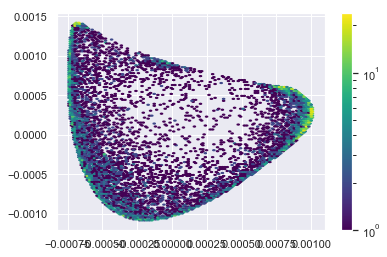

In [207]:
plt.hexbin(emb_results[:,0],emb_results[:,1],cmap='viridis',mincnt=1,bins='log',gridsize=(100,100))
plt.colorbar()

In [209]:

new_d = emb_results[:,0]
d_res = np.zeros_like(dd['img'].get_data())

rand_samps_mask_vec = np.squeeze(np.where(mask.ravel()))[rand_samps]
d_res[np.unravel_index(rand_samps_mask_vec,d_res.shape)] = new_d


new_img = nb.Nifti1Image(d_res,affine=dd['img'].affine,header=dd['img'].header)
new_img.to_filename('/data/neuralabc/carfra/QuantMetComp/processing/MPM/subXXXX_SpectEmb_1.nii.gz')

new_d = emb_results[:,1]
d_res = np.zeros_like(dd['img'].get_data())
rand_samps_mask_vec = np.squeeze(np.where(mask.ravel()))[rand_samps]
d_res[np.unravel_index(rand_samps_mask_vec,d_res.shape)] = new_d
new_img = nb.Nifti1Image(d_res,affine=dd['img'].affine,header=dd['img'].header)
new_img.to_filename('/data/neuralabc/carfra/QuantMetComp/processing/MPM/subXXXX_SpectEmb_2.nii.gz')

In [210]:
new_img.get_data().max()

0.001418284

0.0
(176, 200, 160)
(176, 200, 160)
1309057
<class 'numpy.ndarray'>
(1309057,)


AttributeError: module 'numpy' has no attribute 'cor'

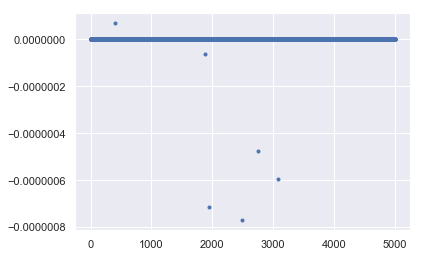

In [202]:
new_d = emb_results[:,0]
print(np.sum(new_d-emb_results[:,0]))
_d = np.zeros_like(dd['img'].get_data())

rand_samps_mask_vec = np.squeeze(np.where(mask.ravel()))[rand_samps]
_d[np.unravel_index(rand_samps_mask_vec,_d.shape)] = new_d

print(_d.shape)
print(mask.shape)
print(mask.sum())
print(type(mask))
print(_d[mask].shape)
print("===================")

rand_samps
_d[mask].ravel()[rand_samps]
plt.plot(_d[np.unravel_index(rand_samps_mask_vec,_d.shape)]-new_d,'.')
np.corrcoef(_d[np.unravel_index(rand_samps_mask_vec,_d.shape)],new_d)

# Multiprocessing

In [17]:
from scipy.stats import zscore
reg_dir = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/Corticalmasked_vs_subcortical/'
reg_data = pd.read_csv(join(reg_dir,'cortical_sheath.csv'), index_col=0)#'cortical_sheath.csv'), index_col=0)

reg_data = reg_data.apply(zscore)
pca = PCA(n_components=6)
pca.fit(reg_data)
#######################
def Principle_Component(sub_id):
    
    seg_by = 'cortex_MD_R2_cap'

    mesh_dir = '/data/neuralabc/carfra/QuantMetComp/source/masks_created/'

    in_dir = join(source_dir,sub_id)
    output_dir = join(out_dir,'PCA',sub_id,seg_by) 
    
    if not os.path.exists(join(output_dir,'mapped')):

        dd = get_sub_data(in_dir,sub_id)
        d = dd['data']
        mask_dir = join(seg_dir,sub_id)
        mask = nb.load(join(mask_dir,seg_by+'.nii.gz')).get_data().astype(bool)

        if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print('Created your directory: {}'.format(output_dir))

        for iii in np.arange(d.shape[-1]):
            data = d[...,iii][mask]
            if iii == 0:
                df = pd.DataFrame({name[iii]:data})
            else:
                df[name[iii]] = data
        df['FA'][df['FA']>1] = 1

        ###################

        df = df.apply(zscore)

        ##################

        res = pca.transform(df)

        ####################

#         mesh = nighres.surface.levelset_to_mesh(join(mesh_dir,sub_id,'cortex_ls_l.nii.gz'), 
#                                                 connectivity='18/6', 
#                                                 level=0.0, 
#                                                 inclusive=True, 
#                                                 save_data=True,
#                                                 overwrite=False,
#                                                 output_dir=join(mesh_dir,sub_id),
#                                                 file_name='cortex_ls_l')
                                                

        for ii in range(6):
            brain = np.zeros_like(dd['data'][...,0])
            brain[mask] = res[:,ii]
            out_name = join(output_dir,sub_id+'_PC_{}_{}.nii.gz'.format(ii+1, seg_by))
            new_img = nb.Nifti1Image(brain,affine=dd['img'].affine,header=dd['img'].header)
            nesegw_img.to_filename(out_name)

#             nighres.surface.surface_mesh_mapping(intensity_image = out_name, 
#                                                  surface_mesh = mesh['result'], 
#                                                  inflated_mesh=None, 
#                                                  mapping_method='closest_point', 
#                                                  save_data=True, 
#                                                  overwrite=True, 
#                                                  output_dir=join(output_dir,'mapped'), 
#                                                  file_name=os.path.basename(out_name).strip('.nii.gz'))

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [23]:
None==None

True

In [18]:
import pathos.multiprocessing as multiprocessing
pool = multiprocessing.ProcessingPool(nodes=10)

import time
now = time.time()

res = pool.map(Principle_Component,sub_ids)

pool.close()
#Needed to completely destroy the pool so that pathos doesn't reuse
pool.clear()

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1012/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1004/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1018/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1026/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1007/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1022/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1033/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1037/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetC

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1002/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1020/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1009/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1027/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1005/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1016/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1024/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1034/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1030/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1038/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1021/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1028/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1010/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1040/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1003/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1036/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1006/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1031/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1017/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1025/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1041/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1047/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1054/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1050/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1060/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1066/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1089/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1074/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1080/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3003/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1043/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1051/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1062/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1048/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1055/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1077/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1084/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1070/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3001/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3004/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1046/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1052/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1049/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1059/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1086/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1064/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1078/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub1072/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3005/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3002/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3006/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3010/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3013/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3018/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3024/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3021/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3033/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3027/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3036/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3030/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3014/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3007/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3019/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3022/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3011/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3025/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3028/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3034/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3031/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3037/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3017/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3020/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3029/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3009/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3012/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3026/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3023/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3035/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3032/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3038/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3039/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3042/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3047/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3050/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3040/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3045/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3048/cortex_MD_R2_cap
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3051/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationW

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3041/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3046/cortex_MD_R2_cap


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/PCA/sub3049/cortex_MD_R2_cap


In [13]:
from scipy.stats import zscore
reg_dir = '/data/neuralabc/carfra/QuantMetComp/processing/MPM/MPM_correlations/Cortical_vs_subcortical/'
reg_data = pd.read_csv(join(reg_dir,'cortical_sheath.csv'), index_col=0)#'subcortical_GM.csv'), index_col=0)

reg_data = reg_data.apply(zscore)
ica = FastICA(n_components=3)
ica.fit(reg_data)

#######################
def Independent_Component(sub_id):
    
    seg_by = 'cortex'

    mesh_dir = '/data/neuralabc/carfra/QuantMetComp/source/masks_created/'

    in_dir = join(source_dir,sub_id)
    output_dir = join(out_dir,'ICA',sub_id,seg_by) 
    
    if not os.path.exists(join(output_dir,'mapped')):

        dd = get_sub_data(in_dir,sub_id)
        d = dd['data']
        mask_dir = join(seg_dir,sub_id)
        mask = nb.load(join(mask_dir,seg_by+'.nii.gz')).get_data().astype(bool)

        if not os.path.exists(output_dir):
                os.makedirs(output_dir)
                print('Created your directory: {}'.format(output_dir))

        for iii in np.arange(d.shape[-1]):
            data = d[...,iii][mask]
            if iii == 0:
                df = pd.DataFrame({name[iii]:data})
            else:
                df[name[iii]] = data
        df['FA'][df['FA']>1] = 1

        ###################

        df = df.apply(zscore)

        ##################

        res = ica.transform(df)

        ####################

        mesh = nighres.surface.levelset_to_mesh(join(mesh_dir,sub_id,'cortex_ls_l.nii.gz'), 
                                                connectivity='18/6', 
                                                level=0.0, 
                                                inclusive=True, 
                                                save_data=True,
                                                overwrite=False,
                                                output_dir=join(mesh_dir,sub_id),
                                                file_name='cortex_ls_l')

        for ii in range(3):
            brain = np.zeros_like(dd['data'][...,0])
            brain[mask] = res[:,ii]
            out_name = join(output_dir,sub_id+'_IC_{}_{}.nii.gz'.format(ii+1, seg_by))
            new_img = nb.Nifti1Image(brain,affine=dd['img'].affine,header=dd['img'].header)
            new_img.to_filename(out_name)

            nighres.surface.surface_mesh_mapping(intensity_image = out_name, 
                                                 surface_mesh = mesh['result'],#join(mesh_dir,sub_id,sub_id+'_l2m-mesh.vtk'), 
                                                 inflated_mesh=None, 
                                                 mapping_method='closest_point', 
                                                 save_data=True, 
                                                 overwrite=True, 
                                                 output_dir=join(output_dir,'mapped'), 
                                                 file_name=os.path.basename(out_name).strip('.nii.gz'))

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [14]:
import pathos.multiprocessing as multiprocessing
pool = multiprocessing.ProcessingPool(nodes=10)

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationW

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1012/cortex
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1026/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1018/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1022/cortex
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1004/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1001/cortex
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1029/cortex
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1007/cortex
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1033/cortex
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1037/cortex

Levelset to Mesh
Levelset to Mesh

Levelset to Mesh

Levelset to Mesh
Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1012/
Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1026/



Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1004/

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1018/


Levelset to Meshski

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1016/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor


Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1016/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1016/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1009/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Levelset to Mesh

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1009/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1009/cortex/mapped/
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1020/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1020/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationW


Surface mesh mappingCreated your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1002/cortex


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1020/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Levelset to MeshCreated your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1027/cortex


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1002/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1027/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1002/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1027/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1005/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1030/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata


Levelset to Mesh
Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1005/


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1030/skip computation (use existing results)

skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1005/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1030/cortex/mapped/

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1024/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1038/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1024/
skip computation (use existing results)

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1038/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1024/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1038/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1034/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1034/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1034/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1020/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1009/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1016/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1002/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1021/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1021/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1021/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1040/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1040/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1040/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1010/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1010/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mappingCreated your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1031/cortex


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1010/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1031/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1031/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1003/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1003/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1003/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1017/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1017/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1017/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1028/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1028/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1028/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1006/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1006/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1006/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1025/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1025/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1025/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1036/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1036/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1036/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1021/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1010/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1040/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1003/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1025/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1041/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1047/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1041/
skip computation (use existing results)

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1047/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1041/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1047/cortex/mapped/

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1050/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1050/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1050/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1054/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1060/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1054/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1060/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1054/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1060/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1066/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1066/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1066/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1074/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1074/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1074/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1080/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1089/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1080/
skip computation (use existing results)

Levelset to Mesh

Surface mesh mapping
Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1089/


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1080/cortex/mapped/skip computation (use existing results)


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1089/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1047/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1041/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1050/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3003/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1054/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1060/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3003/
Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1066/cortex/mapped/

skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3003/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1074/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1080/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1048/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor


Levelset to Mesh

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1048/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1048/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1051/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1051/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3003/cortex/mapped/
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1062/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1051/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_d


Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1062/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()


skip computation (use existing results)
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1070/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1062/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1070/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1070/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1055/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1043/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1055/
skip computation (use existing results)

Levelset to Mesh

Surface mesh mapping
Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1043/


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1055/cortex/mapped/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1043/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3001/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3001/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3001/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1077/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1048/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1077/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app


skip computation (use existing results)

Surface mesh mapping

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1077/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1084/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1051/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1084/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3004/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1084/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3004/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3004/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1070/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1062/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1055/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1077/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1049/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1049/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1049/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1084/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3001/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1052/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Levelset to Mesh

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1052/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1052/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1059/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1059/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1059/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1072/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3004/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1072/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1072/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1064/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1064/
skip computation (use existing results)
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1046/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1064/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1046/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1046/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1049/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1078/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1078/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1078/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1086/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub1086/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1086/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1052/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1059/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3002/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3002/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3002/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1072/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1046/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3005/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1064/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3005/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1049/cortex/mapped/skip computation (use existing results)


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3005/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1086/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1078/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1046/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3005/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1064/cortex/mapped/
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3006/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3006/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3006/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1086/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub1078/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3010/cortex

Levelset to Mesh

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3010/
skip computation (use existing results)
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3013/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3010/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3013/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3013/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3002/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3005/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3018/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Levelset to Mesh


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3018/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3018/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3006/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3021/cortex
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3024/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3021/
skip computation (use existing results)

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3024/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3021/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3024/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3027/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3027/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3027/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3030/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3030/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3030/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3010/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3013/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3033/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3033/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3006/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3033/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3036/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3036/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3036/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3018/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3021/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3024/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3027/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3033/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3007/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3021/cortex/mapped/

Surface mesh mapping
Levelset to Mesh


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3024/cortex/mapped/

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3007/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3007/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3018/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3036/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3011/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3011/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3011/cortex/mapped/

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app




Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3027/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3030/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3014/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3014/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3014/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3033/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3022/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3025/cortex

Levelset to Mesh


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3022/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping
Levelset to Mesh


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3025/
Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3022/cortex/mapped/

skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3025/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3019/cortex

Levelset to Mesh
Surface mesh mapping


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3019/
Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3007/cortex/mapped/

skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3019/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3036/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3011/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3014/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3028/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3028/Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3031/cortex

skip computation (use existing results)

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3031/

Surface mesh mappingskip computation (use existing results)


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3028/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3031/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3022/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3025/cortex/mapped/
Surface mesh mapping


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3019/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3034/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3034/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3034/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3007/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3014/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3037/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3037/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3037/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3011/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3031/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3022/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3028/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3034/cortex/mapped/
Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3017/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3017/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3017/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3009/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3009/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3009/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3012/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3012/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3012/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3037/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3031/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3023/cortex


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Levelset to Mesh

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3023/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3023/cortex/mapped/

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0



Surface mesh mapping

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3028/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3020/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3020/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3020/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3017/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3009/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3026/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3026/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3026/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3034/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3012/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3037/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3032/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3023/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3032/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3032/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()




Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3020/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3029/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3029/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3017/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3029/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3009/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3026/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3012/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3035/cortex

Levelset to Mesh

Surface mesh mapping
Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3035/


Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3023/cortex/mapped/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app



Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3035/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: get_data() is deprecated in favor of get_fdata

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3038/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3038/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3038/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3032/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3020/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3039/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3039/
skip computation (use existing results)


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3042/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3039/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3042/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3042/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3029/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3026/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3047/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3047/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3047/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3050/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3050/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3050/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3035/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3038/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3032/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3039/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d


Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3047/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predict

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3040/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3040/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3040/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3045/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3045/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3045/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3051/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3051/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3051/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3040/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3048/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3048/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3048/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3045/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3051/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3040/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3048/cortex/mapped/

Surface mesh mapping

Outputs will be sav

/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3041/cortex

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3051/cortex/mapped/

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3041/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3041/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3048/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3046/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3046/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3046/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3041/cortex/mapped/


/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  app.launch_new_instance()
/opt/quarantine/anaconda3/2019.10/install/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: get_d

Created your directory: /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3049/cortex

Levelset to Mesh

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/source/masks_created/sub3049/
skip computation (use existing results)

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3049/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3046/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3041/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3046/cortex/mapped/

Surface mesh mapping

Outputs will be saved to /data/neuralabc/carfra/QuantMetComp/processing/MPM/Dim_Reduction/ICA/sub3049/cortex/mapped/

Surface mesh mapping

Outputs will be sav

In [15]:
import time
now = time.time()

res = pool.map(Independent_Component,sub_ids)

pool.close()
#Needed to completely destroy the pool so that pathos doesn't reuse
pool.clear()